# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#explore the portfolio dataframe
print(portfolio.shape)
portfolio.head()


(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
print(profile.shape)
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
print(transcript.shape)
transcript.head()

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## DATA CLEANING

In [5]:
# check for missing values
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [6]:
#check for duplicates
portfolio['id'].duplicated().sum()

0

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
#check for missing values
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [9]:
#fill the missing values of the income column with the mean of the income
income_mean = round(profile['income'].mean())
profile['income'].fillna(value=income_mean, inplace=True)


In [10]:
# fill the gender column with the mode gender
gender_mode = profile['gender'].mode()
profile['gender'].fillna(value = "M", inplace = True)
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,M,68be06ca386d4c31939f3a4f0e3dd783,65405.0
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,M,38fe809add3b4fcf9315a9694bb96ff5,65405.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,M,a03223e636434f42ac4c3df47e8bac43,65405.0


In [11]:
#check for duplicates
profile['id'].duplicated().sum()

0

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              17000 non-null object
id                  17000 non-null object
income              17000 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
#check for missing values
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [14]:
#check for duplicates
transcript['person'].duplicated().sum()

289534

In [15]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [16]:
#get the dummy variable for offer_type
dummy1 = pd.get_dummies(portfolio['offer_type'])
dummy1.head()

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [17]:
portfolio= pd.concat([portfolio, dummy1], axis=1)

In [18]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,0,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,0,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,0,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,0,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,0


In [19]:
#get the dummy for channels 
dummy2 = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)

In [20]:
portfolio = pd.concat([portfolio, dummy2], axis=1)
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


In [21]:
# drop the channels column
portfolio= portfolio.drop(['channels'], axis = 1)

In [22]:
#rename the id column to offer_id
portfolio.rename(columns={"id": "offer_id"}, inplace = True)

In [23]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


In [24]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              17000 non-null object
id                  17000 non-null object
income              17000 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [25]:
profile.head(2)

,age,became_member_on,gender,id,income
0,118,20170212,M,68be06ca386d4c31939f3a4f0e3dd783,65405.0
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [26]:
# change the data_type of the became_member_on column to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format="%Y%m%d")

In [27]:
profile.head(2)

,age,became_member_on,gender,id,income
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65405.0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [28]:
#fill the missing values of the income column with the mean of the income
income_mean = round(profile['income'].mean())
profile['income'].fillna(value=income_mean, inplace=True)

In [29]:
profile.head(2)


,age,became_member_on,gender,id,income
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65405.0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [30]:
# fill the gender column with the mode gender
gender_mode = profile['gender'].mode()
profile['gender'].fillna(value = gender_mode, inplace = True)
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65405.0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65405.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,M,a03223e636434f42ac4c3df47e8bac43,65405.0


In [31]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [32]:
# get the dummy for the event
dummy3 = pd.get_dummies(transcript['event'])

In [33]:
# concatenate the dummy variable with the transcript data
transcript = pd.concat([transcript, dummy3], axis=1)

In [34]:
transcript.head()

,event,person,time,value,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [35]:
# rename the 'person' column to id for consistency
transcript.rename(columns={"person": "id"}, inplace = True)

In [36]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [37]:
# extract the offer id from the value column
transcript['offer_id'] = transcript['value'].apply(lambda a : a.get('offer_id'))
transcript['offer id'] = transcript['value'].apply(lambda a : a.get('offer id'))


In [38]:
transcript.head()

,event,id,time,value,offer completed,offer received,offer viewed,transaction,offer_id,offer id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,None,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,None,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,None,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,None,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,None,4d5c57ea9a6940dd891ad53e9dbe8da0


In [39]:
#merging the 2 columns ('offer id' and 'offer_id')
transcript['offer_id'] = transcript.apply(lambda a : a['offer id'] if a['offer_id'] == None else a['offer_id'],axis = 1)

In [40]:
# drop the value and offer id columns
transcript.drop(['value','offer id'], axis =1, inplace = True)

In [41]:
transcript.head()

,event,id,time,offer completed,offer received,offer viewed,transaction,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [42]:
df = pd.merge(transcript,profile,on='id')
df.head()

,event,id,time,offer completed,offer received,offer viewed,transaction,offer_id,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,75,2017-05-09,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,75,2017-05-09,F,100000.0


In [43]:
df['event'].nunique()

4

In [44]:
df_new = pd.merge(df,portfolio, how = 'outer', on = 'offer_id')


In [45]:
df_new['event'].unique()

array(['offer received', 'offer viewed', 'offer completed', 'transaction'], dtype=object)

In [46]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 23 columns):
event               306534 non-null object
id                  306534 non-null object
time                306534 non-null int64
offer completed     306534 non-null uint8
offer received      306534 non-null uint8
offer viewed        306534 non-null uint8
transaction         306534 non-null uint8
offer_id            167581 non-null object
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
gender              306534 non-null object
income              306534 non-null float64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
reward              167581 non-null float64
bogo                167581 non-null float64
discount            167581 non-null float64
informational       167581 non-null float64
email               167581 non-null float64
mobile             

In [47]:
df_new.isna().sum()

event                    0
id                       0
time                     0
offer completed          0
offer received           0
offer viewed             0
transaction              0
offer_id            138953
age                      0
became_member_on         0
gender                   0
income                   0
difficulty          138953
duration            138953
offer_type          138953
reward              138953
bogo                138953
discount            138953
informational       138953
email               138953
mobile              138953
social              138953
web                 138953
dtype: int64

In [48]:
df_new.dropna(axis = 0, inplace = True)

## Exploratory Data Analysis



In [49]:
#create a function for the label to avoid repetition of codes
def label (x,y,z):
    """
    Args:
    x(str): x-axis title
    y(str): y-axis title
    z(str): main title
    
    returns:
    None
    
    """
    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(z)
    plt.show()

In [50]:
df_new['income'].min()

30000.0

In [51]:
# BEFORE PLOTTING A HISTOGRM I WOULD SET THE BINS
bins = np.arange(df_new['income'].min(),df_new['income'].max()+100,5000)

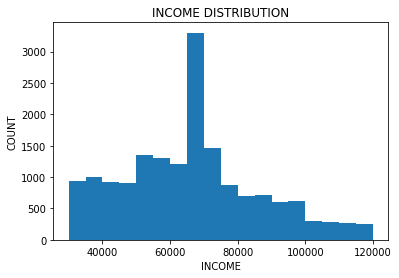

In [52]:
# PLOT THE HISTOGRAM
plt.hist(data = profile, x = 'income', bins = bins);
label('INCOME', 'COUNT','INCOME DISTRIBUTION')

The income data is normally distributed

In [53]:
# BEFORE PLOTTING A HISTOGRM I WOULD SET THE BINS
bins = np.arange(0,df_new['age'].max()+10,5)

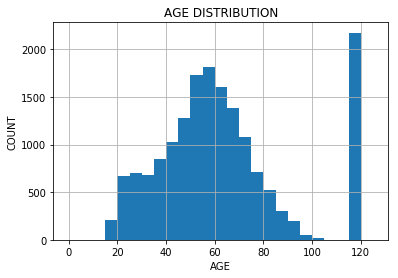

In [54]:
profile.age.hist(bins = bins)
label('AGE','COUNT','AGE DISTRIBUTION')

The age data is normally distributed. there is an outliner in the data

In [55]:
# BEFORE PLOTTING A HISTOGRM I WOULD SET THE BINS
bins = np.arange(0,df_new['time'].max()+10,30)

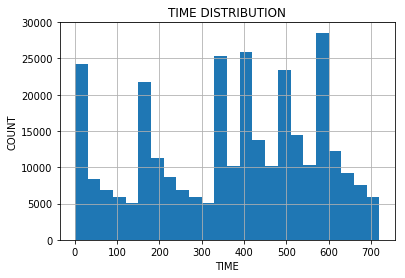

In [56]:
transcript.time.hist(bins = bins)
label('TIME','COUNT','TIME DISTRIBUTION');


The time does not follow a particular pattern

In [57]:
import seaborn as sns
# select the color pallete
base_color = sns.color_palette()[0]

In [58]:
# get the order at which the bars are going to be arranged
stat_count = df_new['gender'].value_counts()
stat_count
stat_order = stat_count.index
stat_order

Index(['M', 'F', 'O'], dtype='object')

In [59]:
# scale the data to be percent
n_gender = df_new['gender'].value_counts().sum()
max_count = stat_count[0]
max_prop = max_count / n_gender
max_prop

0.60670362391917942

In [60]:
# set the proportions and tick names
tick_props = np.arange(0,max_prop,0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

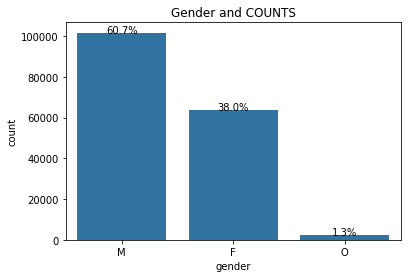

In [61]:
# create a bar chart
sns.countplot(data = df_new, x = 'gender', color = base_color, order = stat_order)
stat_count = df_new['gender'].value_counts()

# get the current tick locations and labels
locs, labels = plt.xticks()
plt.title('Gender and COUNTS')

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = stat_count[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_gender)

    # print the annotation just below the top of the bar
    plt.text(loc, count+2, pct_string, ha = 'center', color = 'black')


The Male gender makes up 52.4% of the data. I left the O gender to include non-binary genders

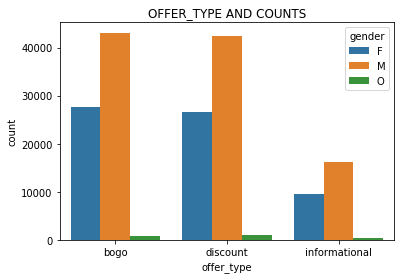

In [62]:
# CREATE A COUNT PLOT OF THE OFFER TYPE
term_order = df_new['offer_type'].value_counts().index
sns.countplot(data = df_new, x='offer_type',hue='gender', order = term_order)
plt.title('OFFER_TYPE AND COUNTS');

The Male gender clearly dominate all the offer_type

# DATA PREPROCESSING

## FEATURE SCALING

Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step. For this project I would be using the StandardScaler. StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.

In [63]:
from sklearn.preprocessing import StandardScaler
# scale the quantitative variables
scaler = StandardScaler()
int_var = ['income', 'difficulty','duration']
df_new[int_var] = scaler.fit_transform(df_new[int_var])

In [64]:
df_new.head()

,event,id,time,offer completed,offer received,offer viewed,transaction,offer_id,age,became_member_on,...,duration,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3,offer received,e2127556f4f64592b11af22de27a7932,408,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


## PCA

Principal component analysis, or PCA, is a statistical procedure that allows you to summarize the information content in large data tables by means of a smaller set of “summary indices” that can be more easily visualized and analyzed

In [65]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
model = PCA()

pca = model.fit(df_new[int_var])

pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

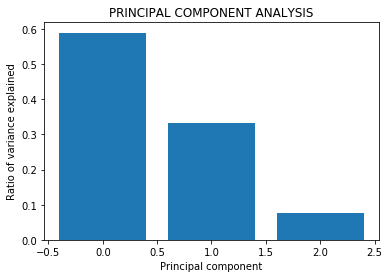

In [66]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("PRINCIPAL COMPONENT ANALYSIS")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

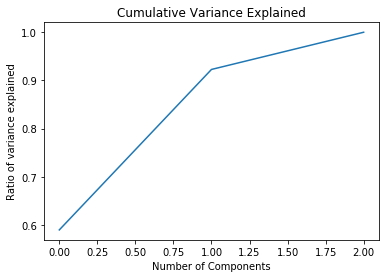

In [67]:
# Investigate the variance accounted for by each principal component.
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

# Modeling

Before modeling the data, I did some further feature enginnering

The data would be trained using 4 machine learning models

Random Forest Classifier: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Ada Boost:An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. 

Naive Bayes: Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable

K-Nearest Neighbor: KNN is a non-parametric and lazy learning algorithm. Non-parametric means there is no assumption for underlying data distribution. In other words, the model structure determined from the dataset.

In [68]:
df_new['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [69]:
# reengineer the event column
events = {'offer received':0, 'offer viewed':1, 'offer completed':2}

In [70]:
# replace the event values to numerical values
df_new['event'].replace(events, inplace = True)

In [71]:
df_new.head()

,event,id,time,offer completed,offer received,offer viewed,transaction,offer_id,age,became_member_on,...,duration,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,2,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3,0,e2127556f4f64592b11af22de27a7932,408,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
4,1,e2127556f4f64592b11af22de27a7932,420,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,...,0.182228,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [72]:
#reengineer the gender variable
gender = {'M':0, 'F':1, 'O' :2}

In [73]:
df_new['gender'].replace(gender, inplace = True)

In [74]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306533
Data columns (total 23 columns):
event               167581 non-null int64
id                  167581 non-null object
time                167581 non-null int64
offer completed     167581 non-null uint8
offer received      167581 non-null uint8
offer viewed        167581 non-null uint8
transaction         167581 non-null uint8
offer_id            167581 non-null object
age                 167581 non-null int64
became_member_on    167581 non-null datetime64[ns]
gender              167581 non-null int64
income              167581 non-null float64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
reward              167581 non-null float64
bogo                167581 non-null float64
discount            167581 non-null float64
informational       167581 non-null float64
email               167581 non-null float64
mobile              1

## MODELING

In [75]:
#establish the X and y variable
X = df_new[['gender','income','time','duration','difficulty']]
y = df_new['event']

In [76]:
# split the data to train and test data
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3,random_state = 0)

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(117306, 5) (50275, 5) (117306,) (50275,)


In [77]:
#establish the model
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


model1 = KNeighborsClassifier(n_neighbors = 6)
model2 = RandomForestClassifier()
model3 = AdaBoostClassifier()
model4 = GaussianNB()


In [78]:
#fit the model
model = model1.fit(X_train, Y_train)

In [79]:
# predict
y_pred = model1.predict(X_test)

In [80]:
# accuracy_score
from sklearn.metrics import accuracy_score
knn_accuracy = accuracy_score(Y_test,y_pred)
knn_accuracy

0.74130283441074096

In [81]:
model_2 = model2.fit(X_train, Y_train)

In [82]:
# get the acuuracy score of the random forest classifier
y_pred2 = model2.predict(X_test)

rfc_accuracy = accuracy_score(Y_test, y_pred2)

rfc_accuracy

0.71604177026355043

In [83]:
model_3 = model3.fit(X_train, Y_train)

In [84]:
# get the acuuracy score of the Ada classifier
y_pred3 = model3.predict(X_test)

abc_accuracy = accuracy_score(Y_test, y_pred3)

abc_accuracy

0.72403779214321229

In [85]:
#get the accuracy score of the naive bayes classifier
model_4 = model4.fit(X_train, Y_train)
y_pred4 = model4.predict(X_test)

nb_accuracy = accuracy_score(Y_test, y_pred4)

nb_accuracy

0.45426156141223273

In [86]:
data = [['KNN', knn_accuracy], ['RANDOM FOREST',rfc_accuracy ], ['ADA BOOST', abc_accuracy], ['Naive Bayes',nb_accuracy]]

In [87]:

dff = pd.DataFrame(data, columns=['Model', 'Accuracy Score'])

In [88]:
dff

,Model,Accuracy Score
0,KNN,0.741303
1,RANDOM FOREST,0.716042
2,ADA BOOST,0.724038
3,Naive Bayes,0.454262


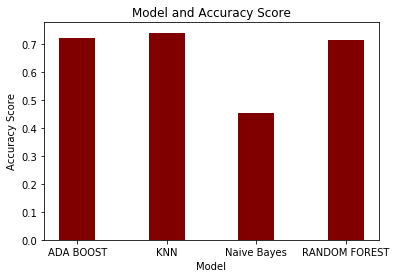

In [89]:
# creating the bar plot
plt.bar(dff['Model'],dff['Accuracy Score'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.title("Model and Accuracy Score")
plt.show();

In [100]:
X = df_new[['time','age','gender','income', 'difficulty', 'duration','bogo','discount','informational']]
y = df_new['offer completed']

In [101]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3,random_state = 0)

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(117306, 9) (50275, 9) (117306,) (50275,)


In [102]:
model_ = model1.fit(X_train, Y_train)
y_pred1 = model1.predict(X_test)

knn_acc = accuracy_score(Y_test, y_pred1)

In [103]:
model_2 = model2.fit(X_train, Y_train)
y_pred2 = model2.predict(X_test)

rfc_acc = accuracy_score(Y_test, y_pred2)

In [104]:
model_3 = model3.fit(X_train, Y_train)
y_pred3 = model3.predict(X_test)

abc_acc = accuracy_score(Y_test, y_pred3)

In [105]:
model_4 = model4.fit(X_train, Y_train)
y_pred4 = model4.predict(X_test)

nb_acc = accuracy_score(Y_test, y_pred4)

In [106]:
data2 = [['KNN', knn_acc], ['RANDOM FOREST',rfc_acc], ['ADA BOOST', abc_acc], ['Naive Bayes',nb_acc]]

In [107]:
model_df = pd.DataFrame(data, columns=['Model', 'Accuracy Score'])
model_df

,Model,Accuracy Score
0,KNN,0.741303
1,RANDOM FOREST,0.716042
2,ADA BOOST,0.724038
3,Naive Bayes,0.454262


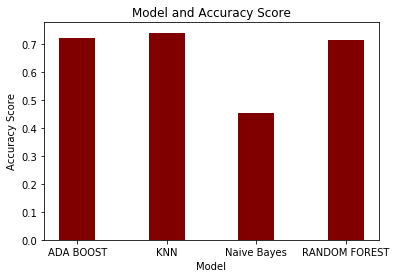

In [108]:
# creating the bar plot
plt.bar(model_df['Model'],model_df['Accuracy Score'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.title("Model and Accuracy Score")
plt.show();

In [99]:
df_new['intercept'] = 1

In [110]:
#
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

log_2 = sm.Logit(df_new['offer completed'], df_new[['time','age','gender','income', 'difficulty', 'duration','bogo','discount','informational']])

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [111]:
result = log_2.fit()

         Current function value: inf
         Iterations: 35


/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [114]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:               Logit             No. Iterations:    35.0000    
Dependent Variable:  offer completed   Pseudo R-squared:  -inf       
Date:                2023-02-16 07:08  AIC:               inf        
No. Observations:    167581            BIC:               inf        
Df Model:            8                 Log-Likelihood:    -inf       
Df Residuals:        167572            LL-Null:           -4.7344e+07
Converged:           0.0000            Scale:             1.0000     
---------------------------------------------------------------------
               Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
---------------------------------------------------------------------
time            0.0016    0.0000  47.3158 0.0000     0.0015    0.0017
age            -0.0094    0.0003 -33.1942 0.0000    -0.0099   -0.0088
gender          0.2803    0.0124  22.6921 0.0000     0.2561    0.3045
income          0.1978    0.0065  30.6574 0.0000     0.1852    0.2105
difficulty     -0.1476    0.0099 -14.9039 0.0000    -0.1670   -0.1282
duration        0.1398    0.0120  11.6875 0.0000     0.1164    0.1633
bogo           -1.4088    0.0242 -58.2059 0.0000    -1.4562   -1.3613
discount       -1.2604    0.0256 -49.1408 0.0000    -1.3106   -1.2101
informational -27.3125 4794.3074  -0.0057 0.9955 -9423.9822 9369.3573
=====================================================================

"""

All the independent variable are statistically significant. However, the R-square is negative infinite which means the model fits the data poorly. This might be the cause of the poor prediction accuracy score. We can carry out further cleaning exercise not ruling out the poossiblities of adding more independent variable to the model